In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil
from tensorflow.keras import applications
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
warnings.filterwarnings("ignore")
%matplotlib inline

Mounted at /content/drive


In [2]:
epochs = 100
batch_size = 32
#testsplit = .2
targetx = 150
targety = 150
learning_rate = 0.0001
classes = 4
seed = random.randint(1, 1000)
data_dir = "/content/drive/MyDrive/Cabbage_Dataset/training"
data_dir1 = "/content/drive/MyDrive/Cabbage_Dataset/validation"

In [3]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        #rescale=1./255,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed

)

validation_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed
)

Found 980 images belonging to 4 classes.
Found 212 images belonging to 4 classes.


In [4]:
checkpoint = ModelCheckpoint('MobileNetV2.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

#tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                           # histogram_freq=0,
                            #batch_size=batch_size,
                            #write_graph=False,
                            #update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))

def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=50,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

In [5]:

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam


In [6]:
base_model = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.8)(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
x = Dropout(0.8)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"



model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])


9406464/9406464 [==============================] - 1s 0us/step


In [7]:
t=time.time()
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=len(train_generator),
                                validation_data=validation_generator,
                                validation_steps=len(validation_generator),
                                epochs=epochs,
                                callbacks=[reducelr])

#compute the training time
print('Training time: %s' % (time.time()-t))

Epoch 1/100
31/31 [==============================] - 769s 25s/step - loss: 1.5297 - accuracy: 0.4296 - val_loss: 0.8216 - val_accuracy: 0.6698 - lr: 1.0000e-04
Epoch 2/100
31/31 [==============================] - 12s 390ms/step - loss: 0.7973 - accuracy: 0.6867 - val_loss: 0.6291 - val_accuracy: 0.7264 - lr: 1.0000e-04
Epoch 3/100
31/31 [==============================] - 12s 388ms/step - loss: 0.6087 - accuracy: 0.7714 - val_loss: 0.5351 - val_accuracy: 0.7877 - lr: 1.0000e-04
Epoch 4/100
31/31 [==============================] - 12s 375ms/step - loss: 0.5097 - accuracy: 0.8092 - val_loss: 0.4145 - val_accuracy: 0.8679 - lr: 1.0000e-04
Epoch 5/100
31/31 [==============================] - 12s 389ms/step - loss: 0.4345 - accuracy: 0.8286 - val_loss: 0.3701 - val_accuracy: 0.8915 - lr: 1.0000e-04
Epoch 6/100
31/31 [==============================] - 12s 386ms/step - loss: 0.3708 - accuracy: 0.8653 - val_loss: 0.3217 - val_accuracy: 0.9104 - lr: 1.0000e-04
Epoch 7/100
31/31 [================

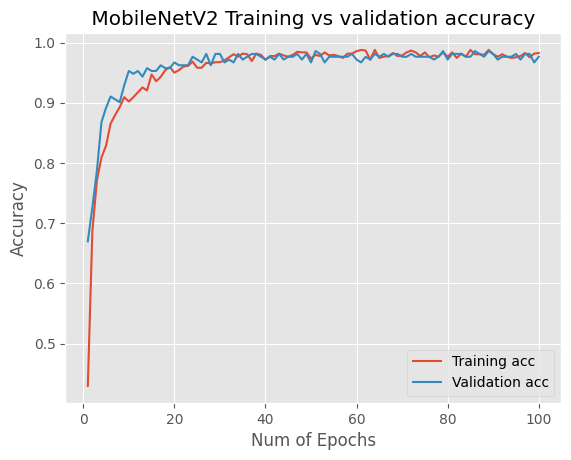

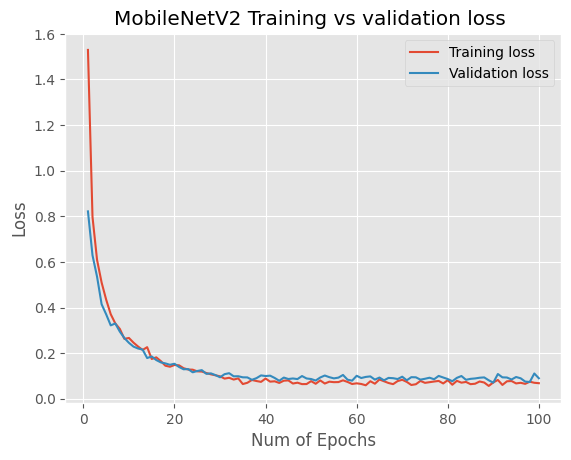

In [8]:
import matplotlib.pyplot as plt
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.style.use('ggplot')

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')
plt.title(' MobileNetV2 Training vs validation accuracy ')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('MobileNetV2 Training vs validation loss ')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
import numpy as np
accuracy = np.array(acc)
print(' Training Accuracy of model is      :   '  , accuracy[-1]*100,'%' )

val_accuracy = np.array(val_acc)
print('  Validation  Accuracy of model is      :   '  , val_accuracy[-1]*100,'%' )

t_loss = np.array(loss)
print('training   loss of   model   is     :   ' , t_loss[-1]*100,'%')
val_loss = np.array(val_loss)
print('Validation  loss of   model  is     :   ' , val_loss[-1]*100,'%')

 Training Accuracy of model is      :    98.26530814170837 %
  Validation  Accuracy of model is      :    97.64150977134705 %
training   loss of   model   is     :    6.8161740899086 %
Validation  loss of   model  is     :    8.975032716989517 %


In [10]:
data_dir1 = "/content/drive/MyDrive/Cabbage_Dataset/testing"

datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        preprocessing_function=preprocess_input
)
val_suffle=False

test_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False,

        #subset="test"
)
score = model.evaluate_generator(test_generator, verbose=1)
print(score)

Found 208 images belonging to 4 classes.
7/7 [==============================] - 131s 22s/step - loss: 0.1405 - accuracy: 0.9567
[0.1404506266117096, 0.9567307829856873]


In [ ]:
import matplotlib.pyplot as plt


ptest_accuracy = 99.1
atest_accuracy = 98.2
vtest_accuracy = 97.1
gtest_accuracy = 98.7
plt.style.use('ggplot')

accuracys = [ptest_accuracy, atest_accuracy, vtest_accuracy, gtest_accuracy]
tick_labels = ["proposed", "AlexNet", "VGG16", "GoogleNet"]
plt.bar(range(4), accuracys)
plt.xlabel('Receiver Operating characteristic(ROC)')
plt.ylabel('Average ROC Under Curve Area in %')
plt.xticks(range(4), tick_labels)
for x_,y_ in zip(range(4), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)

In [ ]:
import matplotlib.pyplot as plt


ptest_accuracy = 96.21
atest_accuracy = 87.50
vtest_accuracy = 87.88
gtest_accuracy = 90.15
plt.style.use('fivethirtyeight')

accuracys = [ptest_accuracy, atest_accuracy, vtest_accuracy, gtest_accuracy]
tick_labels = ["proposed", "AlexNet", "VGG16", "GoogleNet"]
plt.bar(range(4), accuracys)
plt.xlabel('Accuracy')
plt.ylabel('accuracy in %')
plt.xticks(range(4), tick_labels)
for x_,y_ in zip(range(4), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)

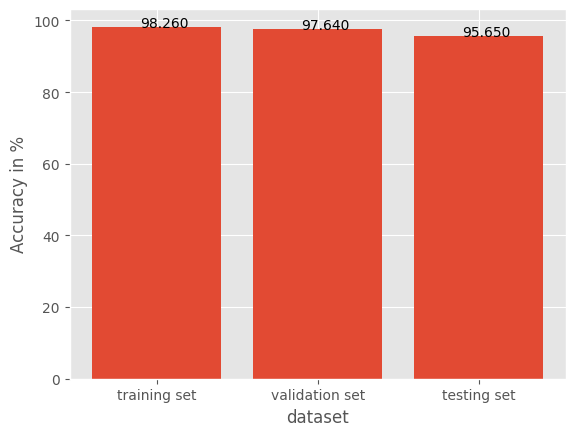

In [11]:
import matplotlib.pyplot as plt

train_accuracy = 98.26
valid_accuracy =97.64
test_accuracy = 95.65
plt.style.use('ggplot')

accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('dataset')
plt.ylabel('Accuracy in %')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()

In [12]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sn
def plot_multiclass_roc(y_pred, y_test, n_classes,class_label, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i,j in enumerate(class_label):
        print(i,j)
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for label {}'.format(np.round(roc_auc[i],2),j))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

6/6 [==============================] - 5s 505ms/step
0 Cabbage_Aphid
1 Cabbage_Black_Rot
2 Cabbage_Healthy
3 Cabbage_Worm_Cut


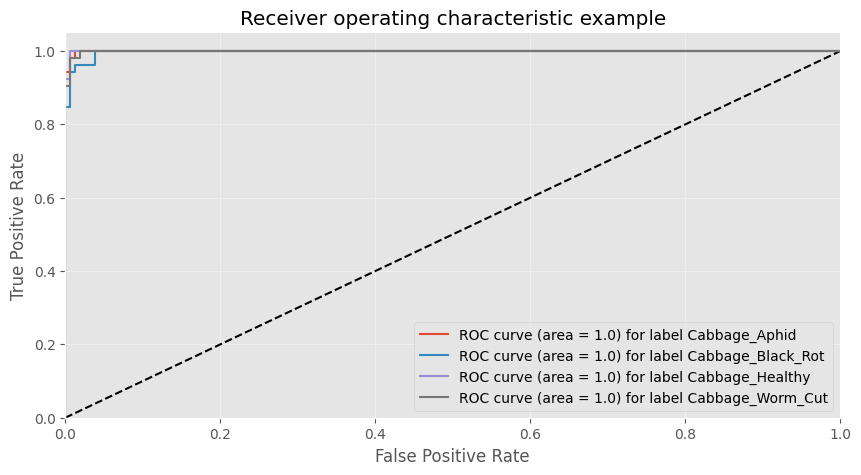

In [13]:
#Alexnet_model.evaluate(valid_set,steps=valid_set.n//batch_size)
#valid_set.reset()

model.evaluate(test_generator,steps=test_generator.n//batch_size)
test_generator.reset()

y_pred=model.predict(test_generator,steps=test_generator.n/batch_size,verbose=1)
class_label=list(test_generator.class_indices.keys())


if val_suffle==True:
  per = np.random.permutation(test_generator.n)
  test_generator.index_array = per
  y_true = test_generator.classes[per]
else:
  y_true = test_generator.classes


plot_multiclass_roc( y_pred, pd.get_dummies(y_true), n_classes=4,class_label=class_label, figsize=(10, 5))

In [ ]:
score = model.evaluate_generator(test_generator, verbose=1)

In [14]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
                   precision    recall  f1-score   support

    Cabbage_Aphid       0.98      1.00      0.99        52
Cabbage_Black_Rot       0.96      0.96      0.96        52
  Cabbage_Healthy       0.98      0.96      0.97        52
 Cabbage_Worm_Cut       0.96      0.96      0.96        52

         accuracy                           0.97       208
        macro avg       0.97      0.97      0.97       208
     weighted avg       0.97      0.97      0.97       208



7/7 [==============================] - 3s 423ms/step


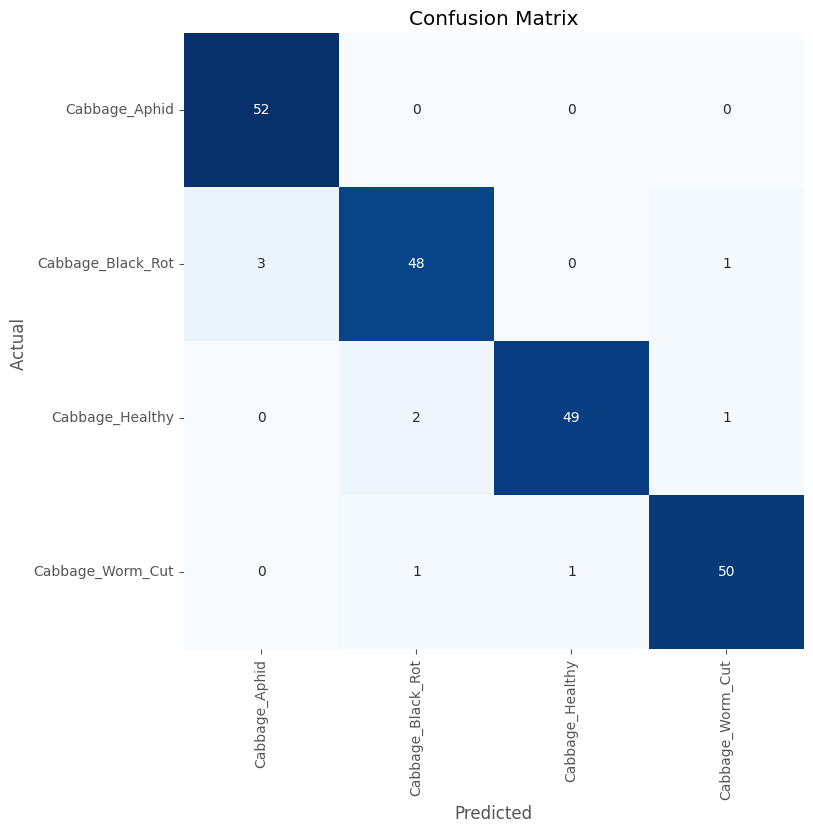

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
classes=['Cabbage_Aphid', 'Cabbage_Black_Rot', 'Cabbage_Healthy','Cabbage_Worm_Cut']

preds=model.predict(test_generator)
y_pred=[]
y_true=[]
for i, p in enumerate(preds):
    y_pred.append(np.argmax(p))
    y_true.append(test_generator.labels[i])
y_pred=np.array(y_pred)
y_true=np.array(y_true)
cm = confusion_matrix(y_true, y_pred )
clr = classification_report(y_true, y_pred, target_names=classes)
length=len(classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual ")
plt.title("Confusion Matrix")
plt.show()